<a href="https://colab.research.google.com/github/SevillaBK/Tensorflow2.0/blob/master/Chapter_6_%EC%BB%A8%EB%B3%BC%EB%A3%A8%EC%85%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**컨볼루션 신경망(Convolution Neural Network, CNN)**은 이미지 분류에 뛰어난 성능을 보여주고 있는 신경망으로, 이미지뿐만 아니라 텍스트, 음성 등 다양한 분야에서도 활용되고 있습니다.

# 1. 합성곱(Convolution)

컨볼루션 신경망을 이해하려면 컨볼루션 연산, 우리말로 합성곱을 먼저 이해해야 합니다.<br/> 
합성곱은 이미지의 특징을 추출하는 기법으로 각 픽셀을 본래 픽셀과 주변의 픽셀의 조합으로 대체하는 동작입니다.<br/>
이 때 연산에 쓰이는 작은 행렬을 **필터(filter)** 또는 **커널(kernel)**이라고 합니다.

원본 이미지의 각 픽셀을 포함한 주변 픽셀과 필터의 모든 픽셀은 각각 곱연산을 하고,<br/>
그 결과를 모두 합해서 변환된 이미지를 만들어줍니다.

![대체 텍스트](https://github.com/injo-image/image/blob/master/tensorflow/chapter6/convolution.png?raw=true)


딥러닝 기반의 컨볼루션 연산은 네트워크가 특징을 추출하는 필터를 자동으로 생성하여<br/>
학습을 계속하면 네트워크를 구성하는 뉴런들은 입력한 데이터에 대해 특정 패턴을 잘 추출할 수 있도록 적응하게 됩니다.

# 2. 주요 레이어 정리

![대체 텍스트](https://github.com/injo-image/image/blob/master/tensorflow/chapter6/general-architecture-convnet.jpg?raw=true)

위의 그림은 이미지 분류에 사용되는 컨볼루션 신경망의 일반적인 구조입니다.<br/>
컨볼루션 신경망은 특징 추출기(Feature Extractor)와 분류기(Classifier)가 합쳐져 있는 형태로<br/>
특징 추출기의 역할을 하는 것은 **컨볼루션 레이어(Convolution Layer)**와 **풀링 레이어(Pooling Layer)**이며<br/>
분류기의 역할은 Dense 레이어가 수행합니다.<br/>
그리고 과적합을 막기 위해 Dense 레이어 사이에 **드롭아웃 레이어(Dropout Layer)**가 배치됩니다.

## 2.1 컨볼루션 레이어

컨볼루션 레이어는 입력된 이미지에 대해 합성곱 연산을 수행하는 레이어입니다.<br/>
이 때 사용되는 필터는 사람이 정하는 것이 아니라 네트워크의 학습을 통해 자동으로 추출됩니다.<br/>
따라서 코드에서 지정하는 값은 필터의 각 셀 값이 아니라 필터의 개수 정도로 필터의 수가 많으면 다양한 특징을 추출할 수 있습니다.

컨볼루션 레이어는 1차원부터 3차원 이상까지 다양한 차원으로 사용할 수 있지만, 이번에는 2차원을 기준으로 학습해보겠습니다.<br/>

이미지는 원색으로 구성된 **채널(Channel)**이 있습니다. 채널은 각 이미지가 가진 색상 정보를 담아 놓는 공간입니다.<br/>
흑백 이미지는 채널이 하나이고, 보통의 컬러이미지는 빨강, 초록, 파랑의 삼원색으로 된 세 개의 채널을 가지고 있습니다.

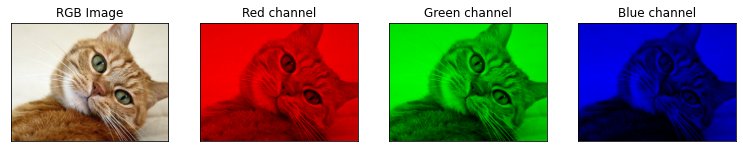

In [1]:
# 컬러 이미지에서 분리된 RGB 채널이미지 예시 출력
import tensorflow as tf
import matplotlib.pyplot as plt

image_path = tf.keras.utils.get_file('cat.jpg', 'http://bit.ly/33U6mH9')
image = plt.imread(image_path)

titles = ['RGB Image', 'Red channel', 'Green channel', 'Blue channel']
cmaps = [None, plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

from numpy import array, zeros_like
def channel(image, color):
    if color not in (0, 1, 2): return image
    c = image[..., color]
    z = zeros_like(c)
    return array([(c, z, z), (z, c, z), (z, z, c)][color]).transpose(1,2,0)
  
colors = range(-1, 3)
fig, axes = plt.subplots(1, 4, figsize=(13,3))
objs = zip(axes, titles, colors)
for ax, title, color in objs:
    ax.imshow(channel(image, color))
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

컨볼루션 레이어는 각 채널에 대해 계산된 값을 합쳐서 새로운 이미지를 만드는데,<br/>
이 때 새로운 이미지의 차원수는 필터와 동일합니다.<br/>
일반적인 컨볼루션 신경망은 뒤쪽 레이어로 갈수록 필터의 수를 점점 늘리기 때문에 마지막 이미지의 차원 수는 점점 많아집니다.

2차원의 이미지를 다루는 컨볼루션 레이어를 생성하는 코드는 아래와 같습니다.

In [0]:
# Conv2D 레이어 생성코드
conv1 = tf.keras.layers.Conv2D(kernel_size = (3,3), strides=(2,2), padding='valid', filters=16)

* kernel_size

 - kernel_size은 필터행렬의 크기입니다. 앞의 숫자는 높이, 뒤의 숫자는 너비입니다.<br/>
숫자를 하나만 사용하면 높이와 너비를 동일한 값으로 사용합니다.

* strides

 - strides는 필터가 계산과정에서 한 스텝마다 이동하는 크기입니다.<br/>
기본 값은 (1,1)이고 (2,2) 등으로 설정하면 한 칸씩 건더뛰면서 계산합니다.<br/>
kernel_size와 마찬가지로 두 수는 높이와 너비를 나타냅니다.

![대체 텍스트](https://github.com/injo-image/image/blob/master/tensorflow/chapter6/strides.png?raw=true)

* padding
 - 컨볼루션 연산 전에 이미지 주변에 빈 값을 넣을지 지정하는 옵션입니다.
 - valid와 same 이라는 두가지 옵션이 있습니다.
 - valid는 위에서 본 것과 같은 방식으로 빈 값을 사용하지 않아, 그 결과 원본 이미지보다 크기가 줄어듭니다.
 - same은 빈 값을 넣어서 출력 이미지의 크기를 원본과 동일하게 만듭니다.

![대체 텍스트](https://github.com/injo-image/image/blob/master/tensorflow/chapter6/padding.png?raw=true)

* filters
 - 필터의 개수로 네트워크가 얼마나 많은 특징을 추출하느냐를 결정합니다.
 - 너무 많이 추출하면 학습이 느려지고 과적합이 발생할 수 있습니다.
 - 유명한 컨볼루션 신경망 네트워크 중 하나인 VGG는 네트워크가 깊어질수록 필터의 수를 2배씩 늘립니다.<br/>(64→128→256→512)

## 2.2 풀링 레이어

이미지를 구성하는 픽셀 중 인접한 픽셀은 비슷한 정보를 많이 가지고 있습니다.<br/>
이런 이미지의 크기를 줄이면서 중요한 정보만을 남기기 위해 서브샘플링이라는 기법을 사용합니다.<br/>
이를 통해 메모리를 효율적으로 사용할 수 있고, 계산할 정보가 줄어 과적합을 방지하는 효과도 있습니다.<br/>
이 과정에서 사용되는 레이어가 풀링 레이어(Pooling Layer)입니다. 

풀링 레이어에는 MaxPooling 레이어, AveragePooling 레이어 등이 있는데,<br/>
컨볼루션 신경망에서는 MaxPooling 레이어가 더 많이 사용됩니다.

In [0]:
# MaxPool2D 레이어 코드
pool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))

* pool_size
 - 한 번에 Max 연산을 수행할 범위입니다.
 - pool_size = (2,2) 이면 높이 2, 너비 2인 사각형 안에서 최대값만 남기는 연산을 합니다.

* strides
 - Conv2D 레이어에서 나온 것과 동일하게 한 스텝마다 이동하는 크기입니다.

 ![대체 텍스트](https://github.com/injo-image/image/blob/master/tensorflow/chapter6/MaxPool2D.png?raw=true)

Pooling 레이어에는 가중치가 존재하지 않기 때문에 학습되지 않으며, 네트워크 구조에 따라 생략되기도 합니다.

## 2.3 드롭아웃 레이어

드롭아웃 레이어는 네트워크의 과적합을 막기 위한 레이어로 학습과정에서 무작위로 뉴런의 부분집합을 제거합니다.<br/>
네트워크가 학습할 때 같은 레이어에 있는 뉴런들은 결과 값에 의해 서로 같은 영향을 받습니다.<br/>
때문에 각 뉴런의 계산 결과를 모두 더해서 나오는 결과 값은 한쪽으로 치우치는데<br/>
이를 막기 위해 드롭아웃 레이어는 확률적으로 일부 뉴런에 대한 연결을 끊고, <br/>
테스트할 때는 정상적으로 모든 값을 포함해서 계산합니다.

In [0]:
# Dropout 레이어 생성코드
dropout = tf.keras.layers.Dropout(rate=0.3)

주요 인수는 rate로 제외할 뉴런의 비율을 나타냅니다.

간단한 레이어지만 AlexNet, GoogLeNet, DenseNet 등 거의 모든 주요 컨볼루션 신경망에 사용됩니다.<br/>
드롭아웃 레이어도 별도의 가중치가 없기 때문에 학습되지 않습니다.

# 3. Fashion MNIST 데이터셋에 적용하기

In [0]:
# Fashion MNIST 데이터셋 불러오기
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_X, train_Y), (test_X, test_Y) = fashion_mnist.load_data()

# 데이터 스케일링
train_X = train_X / 255.0
test_X = test_X / 255.0

Fashion MNIST 데이터는 흑백이미지로 1개의 채널을 갖기 때문에 reshape() 함수를 사용해<br/>
데이터 가장 뒤쪽에 채널 차원을 추가해줍니다.

In [6]:
# reshape 이전
print(train_X.shape, test_X.shape)

train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)

# reshape 이후
print(train_X.shape, test_X.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


데이터 reshape 이후 데이터를 확인해보겠습니다.

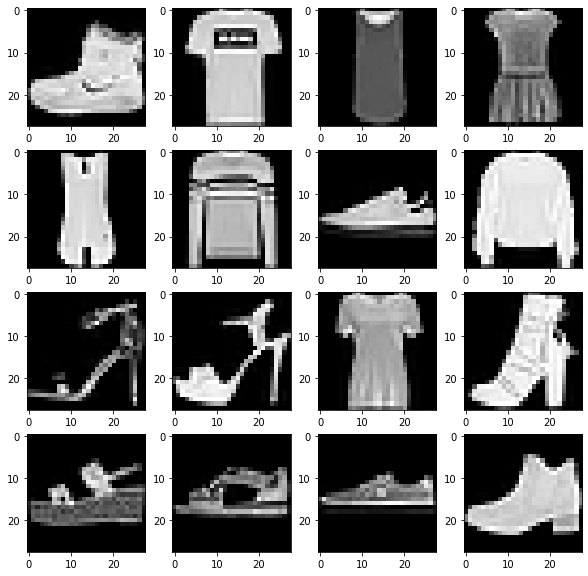

[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9]


In [7]:
# 이미지 데이터 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for c in range(16):
  plt.subplot(4, 4, c+1)
  # 그래프를 그리기 위한 데이터는 2차원이어야 하기 때문에 reshape 함수로 다시 2차원으로 변
  plt.imshow(train_X[c].reshape(28, 28), cmap='gray')

plt.show()

# train 데이터의 첫번째 ~ 16번째 까지의 라벨 
print(train_Y[:16])

먼저 풀링 레이어가 없이 컨볼루션 레이어만 사용한 모델을 정의해보겠습니다.

In [8]:
# 컨볼루션 신경망 정의
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape=(28, 28, 1), kernel_size=(3, 3), filters=16),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=32),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 30976)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3965056   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 3,989,642
Trainable params: 3,989,642
Non-trainable params: 0
______________________________________________

Epoch 1/25
1407/1407 [==============================] - 14s 10ms/step - loss: 0.4583 - accuracy: 0.8366 - val_loss: 0.4021 - val_accuracy: 0.8501
Epoch 2/25
1407/1407 [==============================] - 14s 10ms/step - loss: 0.3339 - accuracy: 0.8781 - val_loss: 0.3716 - val_accuracy: 0.8657
Epoch 3/25
1407/1407 [==============================] - 14s 10ms/step - loss: 0.2835 - accuracy: 0.8964 - val_loss: 0.3687 - val_accuracy: 0.8752
Epoch 4/25
1407/1407 [==============================] - 14s 10ms/step - loss: 0.2397 - accuracy: 0.9099 - val_loss: 0.3994 - val_accuracy: 0.8687
Epoch 5/25
1407/1407 [==============================] - 14s 10ms/step - loss: 0.2074 - accuracy: 0.9238 - val_loss: 0.4307 - val_accuracy: 0.8686
Epoch 6/25
1407/1407 [==============================] - 14s 10ms/step - loss: 0.1835 - accuracy: 0.9318 - val_loss: 0.4546 - val_accuracy: 0.8693
Epoch 7/25
1407/1407 [==============================] - 14s 10ms/step - loss: 0.1673 - accuracy: 0.9390 - val_loss: 0.4786 -

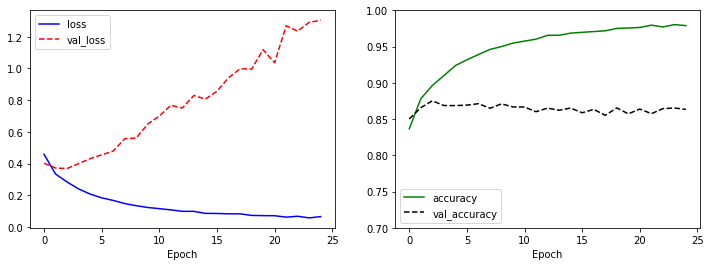

[1.2998040914535522, 0.8604999780654907]

In [9]:
# 컨볼루션 신경망 모델 학습
history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)

# 학습과정의 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

# 모델 성능 평가
model.evaluate(test_X, test_Y, verbose=0)

왼쪽의 그래프를 보면 학습을 할수록 loss는 계속 감소하지만 val_loss는 계속 증가하고 있는 과적합 현상이 보입니다.<br/>
오른쪽 그래프에서도 accuracy는 계속 증가하지만 val_accuracy는 정체 또는 감소하는 모습을 보입니다.

model.evaluate()로 테스트셋에 대한 성능을 측정했을 때도,<br/>
loss는 1.2998, accuracy는 86.05%로 훈련셋의 결과에 크게 못미칩니다.

이번에는 풀링 레이어와 드롭아웃 레이어를 추가하여 모델을 학습시켜 보겠습니다.

In [10]:
# 컨볼루션 신경망 모델 학습(풀링 레이어, 드롭아웃 레이어 추가)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape=(28,28,1), kernel_size=(3,3), filters=32),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

이번 모델의 경우, 컨볼루션 레이어만 가지고 만든 모델보다 파라미터의 수가 상당히 줄어든 것을 볼 수 있습니다.<br/>
이는 풀링 레이어가 이미지의 크기를 줄여주고 있기 때문입니다.<br/>
그리고 Dense 레이어 사이에는 드롭아웃 레이어도 사용되었습니다.<br/>
풀링 레이어와 드롭아웃 레이어는 모두 과적합을 줄이는 역할을 합니다.

이제 이 모델을 학습시키고, 그 결과를 확인해보겠습니다.


Epoch 1/25
1407/1407 [==============================] - 10s 7ms/step - loss: 0.5333 - accuracy: 0.8072 - val_loss: 0.3582 - val_accuracy: 0.8683
Epoch 2/25
1407/1407 [==============================] - 10s 7ms/step - loss: 0.3604 - accuracy: 0.8698 - val_loss: 0.3227 - val_accuracy: 0.8799
Epoch 3/25
1407/1407 [==============================] - 10s 7ms/step - loss: 0.3183 - accuracy: 0.8850 - val_loss: 0.3135 - val_accuracy: 0.8868
Epoch 4/25
1407/1407 [==============================] - 10s 7ms/step - loss: 0.2934 - accuracy: 0.8923 - val_loss: 0.3000 - val_accuracy: 0.8896
Epoch 5/25
1407/1407 [==============================] - 10s 7ms/step - loss: 0.2708 - accuracy: 0.9008 - val_loss: 0.2848 - val_accuracy: 0.8961
Epoch 6/25
1407/1407 [==============================] - 10s 7ms/step - loss: 0.2507 - accuracy: 0.9064 - val_loss: 0.2991 - val_accuracy: 0.8973
Epoch 7/25
1407/1407 [==============================] - 10s 7ms/step - loss: 0.2379 - accuracy: 0.9129 - val_loss: 0.2889 - val_ac

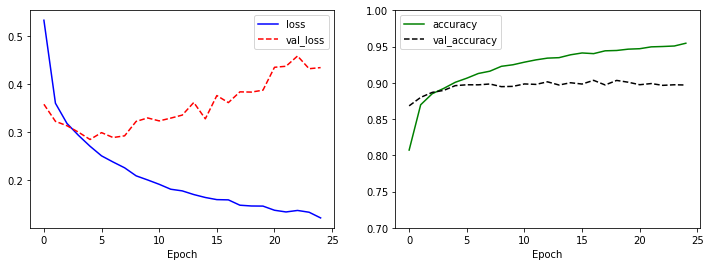

[0.4380030035972595, 0.8931000232696533]

In [11]:
# 컨볼루션 신경망 모델의 학습
history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)

# 학습과정의 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

# 모델 성능 평가
model.evaluate(test_X, test_Y, verbose=0)

위의 그래프를 보면 여전히 과적합 현상은 발생하고 있지만, 먼저 시행된 결과보다는 감소했음을 알 수 있습니다.

다음 포스팅에서는 이 방법 외에 CNN 모델의 퍼포먼스를 더욱 높이기 위한 방법들을 살펴보겠습니다.